In [2]:
import os, pickle
import numpy as np
import torch.nn.functional as F
from oct2py import Oct2Py
import cyipopt
import warnings
from tqdm import trange
from pypower.ext2int import ext2int
from pypower.api import loadcase
from problemDefJITM2 import opfSocp
from problemDefJITR2 import opfSocpR
from utils import make_data_parallel
from tqdm import tqdm, trange
from itertools import zip_longest
import gc
from time import time
from ConvexModel import ConvexNet
from ClassifierModel import ClassifierNet
from RidgeModel import RidgeNet
import xgboost as xgb


from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import RidgeClassifier

octave = Oct2Py()
dir_name = 'data/'
MAX_BUS = 10000
NUM_SOLVES = 30
VIOL_THRES = 1e-5

if __name__ == "__main__":
    
    # get all cases in current directory
    current_directory = os.getcwd()+'/'
    # current_directory = '/home/sbose/pglib-opf/' # for running on BEBOP
    all_files_and_directories = os.listdir(current_directory)
    # three specific cases
    case_files = [current_directory+i for i in ['pglib_opf_case118_ieee.m','pglib_opf_case793_goc.m','pglib_opf_case1354_pegase.m','pglib_opf_case2312_goc.m','pglib_opf_case4601_goc.m','pglib_opf_case10000_goc.m']]
    # case_files = [current_directory+i for i in ['pglib_opf_case2312_goc.m','pglib_opf_case10000_goc.m']]
    # case_files = [current_directory+i for i in ['pglib_opf_case2312_goc.m',"pglib_opf_case4601_goc.m"]]

    cases, casenames = [], []
    cases_full, casenames_full = [], []
    
    for cf in case_files:
        octave.source(current_directory+os.path.basename(cf))
        cname = os.path.basename(cf).split('.')[0]
        num_buses = None
        # determine number of buses in the case from its name
        for ci in cname.split('_'):
            if 'case' in ci:
                num_buses = int(''.join([chr for chr in ci.replace('case','',1) if chr.isdigit()]))
        # fitler out cases with more buses than MAX_BUS
        if num_buses <= MAX_BUS:
            # convert to internal indexing
            case_correct_idx = ext2int(loadcase(octave.feval(cname)))
            # append
            cases.append(case_correct_idx)
            casenames.append(cname)
            
    perc = lambda a,b: (a/b)*100
            
    for cn,this_case in zip(casenames,cases):
        
        print(f"-----\nPlotting case {cn}\n-----\n\n")
        
        # modify the input
        optObj = opfSocp(this_case,cn) # generate object
        
        # output  data for different methods
        # inp_data = np.load(os.getcwd()+f'/saved/{cn}_test_inp.npz')['data'] # input data
        gt_data = np.load(os.getcwd()+f'/saved/{cn}_test_gt.npz')['data'] # ground truth
        convex_data = np.load(os.getcwd()+f'/saved/{cn}_out_convex.npz')['data'] # convex data
        classifier_data = np.load(os.getcwd()+f'/saved/{cn}_out_classifier.npz')['data'] # classifier data
        ridge_data = np.load(os.getcwd()+f'/saved/{cn}_out_ridge.npz')['data'] # ridge data
        if cn not in 'pglib_opf_case10000_goc.m':
            xgboost_data = np.load(os.getcwd()+f'/saved/{cn}_out_xgboost.npz')['data'] # xgboost data
        else:
            xgboost_data = np.ones_like(ridge_data)
        
        # define indices
        # counter = optObj.n_bus*2
        # idx_flow_f = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        # idx_flow_f = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        # idx_ang_min = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        # idx_ang_max = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        
        # calculate gt data
        counter = 0
        counter2 = int(1e+7)
        # gt = gt_data[:,counter:counter2]
        # cnv = convex_data[:,counter:counter2]
        # cla = classifier_data[:,counter:counter2]
        # rdg = ridge_data[:,counter:counter2]
        # xgb = xgboost_data[:,counter:counter2]
        gt = gt_data
        lim = 2*optObj.n_bus
        cnv = convex_data[:,lim:]
        cla = classifier_data[:,lim:]
        rdg = ridge_data[:,lim:]
        xgb = xgboost_data[:,lim:]
        
        total = gt.size
        false = (1-gt).sum()
        true = gt.sum()
        #
        tp_cnv = (gt*cnv).astype(int).sum()
        tn_cnv = ((1-gt)*(1-cnv)).astype(int).sum()
        fp_cnv = ((1-gt)*cnv).astype(int).sum()
        fn_cnv = (gt*(1-cnv)).astype(int).sum()
        #
        tp_cla = (gt*cla).astype(int).sum()
        tn_cla = ((1-gt)*(1-cla)).astype(int).sum()
        fp_cla = ((1-gt)*cla).astype(int).sum()
        fn_cla = (gt*(1-cla)).astype(int).sum()
        #
        tp_rdg = (gt*rdg).astype(int).sum()
        tn_rdg = ((1-gt)*(1-rdg)).astype(int).sum()
        fp_rdg = ((1-gt)*rdg).astype(int).sum()
        fn_rdg = (gt*(1-rdg)).astype(int).sum()
        #
        tp_xgb = (gt*xgb).astype(int).sum()
        tn_xgb = ((1-gt)*(1-xgb)).astype(int).sum()
        fp_xgb = ((1-gt)*xgb).astype(int).sum()
        fn_xgb = (gt*(1-xgb)).astype(int).sum()
        
        print(
            f"default for {cn}:\n & {perc(true,total):.2f}\% & {perc(false,total):.2f}\%\n"
            f"convex:\n & {perc(tp_cnv,total):.2f}\% & {perc(tn_cnv,total):.2f}\% & {perc(fp_cnv,total):.2f}\% & {perc(fn_cnv,total):.2f}\%\n"
            f"classifier:\n & {perc(tp_cla,total):.2f}\% & {perc(tn_cla,total):.2f}\% & {perc(fp_cla,total):.2f}\% & {perc(fn_cla,total):.2f}\%\n"
            f"ridge:\n & {perc(tp_rdg,total):.2f}\% & {perc(tn_rdg,total):.2f}\% & {perc(fp_rdg,total):.2f}\% & {perc(fn_rdg,total):.2f}\%\n"
            f"xgboost:\n & {perc(tp_xgb,total):.2f}\% & {perc(tn_xgb,total):.2f}\% & {perc(fp_xgb,total):.2f}\% & {perc(fn_xgb,total):.2f}\%\n\n"
        )     

-----
Plotting case pglib_opf_case118_ieee
-----


default for pglib_opf_case118_ieee:
 & 11.03\% & 88.97\%
convex:
 & 11.03\% & 86.76\% & 2.21\% & 0.00\%
classifier:
 & 10.95\% & 88.57\% & 0.40\% & 0.08\%
ridge:
 & 10.80\% & 88.80\% & 0.16747374562427073:.2f\% & 0.23\%
xgboost:
 & 10.35\% & 88.94\% & 0.03\% & 0.68\%


-----
Plotting case pglib_opf_case793_goc
-----


default for pglib_opf_case793_goc:
 & 24.70\% & 75.30\%
convex:
 & 24.70\% & 62.06\% & 13.25\% & 0.00\%
classifier:
 & 24.34\% & 65.76\% & 9.54\% & 0.35\%
ridge:
 & 24.03\% & 66.29\% & 9.01647033597341:.2f\% & 0.67\%
xgboost:
 & 9.41\% & 74.93\% & 0.38\% & 15.29\%


-----
Plotting case pglib_opf_case1354_pegase
-----


default for pglib_opf_case1354_pegase:
 & 9.44\% & 90.56\%
convex:
 & 9.44\% & 89.06\% & 1.50\% & 0.00\%
classifier:
 & 9.40\% & 90.05\% & 0.51\% & 0.04\%
ridge:
 & 9.27\% & 90.32\% & 0.2361597491101301:.2f\% & 0.17\%
xgboost:
 & 8.73\% & 90.52\% & 0.04\% & 0.71\%


-----
Plotting case pglib_opf_case2312_go

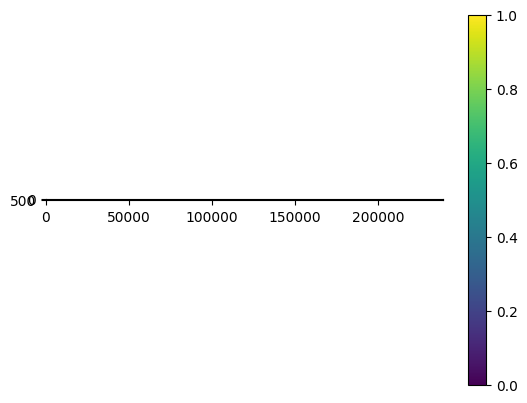

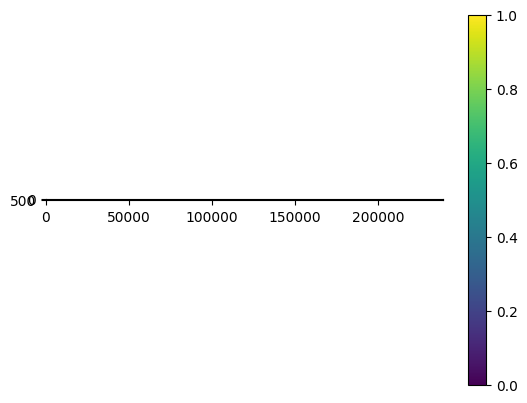

In [3]:
import os, pickle
import numpy as np
import torch.nn.functional as F
from oct2py import Oct2Py
import cyipopt
import warnings
from tqdm import trange
from pypower.ext2int import ext2int
from pypower.api import loadcase
from problemDefJITM2 import opfSocp
from problemDefJITR2 import opfSocpR
from utils import make_data_parallel
from tqdm import tqdm, trange
from itertools import zip_longest
import gc
from time import time
from ConvexModel import ConvexNet
from ClassifierModel import ClassifierNet
from RidgeModel import RidgeNet
import xgboost as xgb


from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import RidgeClassifier

octave = Oct2Py()
dir_name = 'data/'
MAX_BUS = 10000
NUM_SOLVES = 30
VIOL_THRES = 1e-5

if __name__ == "__main__":
    
    # get all cases in current directory
    current_directory = os.getcwd()+'/'
    # current_directory = '/home/sbose/pglib-opf/' # for running on BEBOP
    all_files_and_directories = os.listdir(current_directory)
    # three specific cases
    case_files = [current_directory+i for i in ['pglib_opf_case118_ieee.m','pglib_opf_case793_goc.m','pglib_opf_case1354_pegase.m','pglib_opf_case2312_goc.m','pglib_opf_case4601_goc.m','pglib_opf_case10000_goc.m']]
    # case_files = [current_directory+i for i in ['pglib_opf_case2312_goc.m','pglib_opf_case10000_goc.m']]
    # case_files = [current_directory+i for i in ['pglib_opf_case2312_goc.m',"pglib_opf_case4601_goc.m"]]

    cases, casenames = [], []
    cases_full, casenames_full = [], []
    
    for cf in case_files:
        octave.source(current_directory+os.path.basename(cf))
        cname = os.path.basename(cf).split('.')[0]
        num_buses = None
        # determine number of buses in the case from its name
        for ci in cname.split('_'):
            if 'case' in ci:
                num_buses = int(''.join([chr for chr in ci.replace('case','',1) if chr.isdigit()]))
        # fitler out cases with more buses than MAX_BUS
        if num_buses <= MAX_BUS:
            # convert to internal indexing
            case_correct_idx = ext2int(loadcase(octave.feval(cname)))
            # append
            cases.append(case_correct_idx)
            casenames.append(cname)
            
    perc = lambda a,b: (a/b)*100
            
    for cn,this_case in zip(casenames,cases):
        
        print(f"-----\nPlotting case {cn}\n-----\n\n")
        
        # modify the input
        optObj = opfSocp(this_case,cn) # generate object
        
        # output  data for different methods
        # inp_data = np.load(os.getcwd()+f'/saved/{cn}_test_inp.npz')['data'] # input data
        gt_data = np.load(os.getcwd()+f'/saved/{cn}_test_gt.npz')['data'] # ground truth
        convex_data = np.load(os.getcwd()+f'/saved/{cn}_out_convex.npz')['data'] # convex data
        classifier_data = np.load(os.getcwd()+f'/saved/{cn}_out_classifier.npz')['data'] # classifier data
        ridge_data = np.load(os.getcwd()+f'/saved/{cn}_out_ridge.npz')['data'] # ridge data
        if cn not in 'pglib_opf_case10000_goc.m':
            xgboost_data = np.load(os.getcwd()+f'/saved/{cn}_out_xgboost.npz')['data'] # xgboost data
        else:
            xgboost_data = np.ones_like(ridge_data)
        
        # define indices
        # counter = optObj.n_bus*2
        # idx_flow_f = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        # idx_flow_f = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        # idx_ang_min = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        # idx_ang_max = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        
        # calculate gt data
        counter = 0
        counter2 = int(1e+7)
        # gt = gt_data[:,counter:counter2]
        # cnv = convex_data[:,counter:counter2]
        # cla = classifier_data[:,counter:counter2]
        # rdg = ridge_data[:,counter:counter2]
        # xgb = xgboost_data[:,counter:counter2]
        gt = gt_data
        lim = 2*optObj.n_bus
        cnv = convex_data[:,lim:]
        cla = classifier_data[:,lim:]
        rdg = ridge_data[:,lim:]
        xgb = xgboost_data[:,lim:]
        
        total = gt.size
        false = (1-gt).sum()
        true = gt.sum()
        #
        tp_cnv = (gt*cnv).astype(int).sum()
        tn_cnv = ((1-gt)*(1-cnv)).astype(int).sum()
        fp_cnv = ((1-gt)*cnv).astype(int).sum()
        fn_cnv = (gt*(1-cnv)).astype(int).sum()
        #
        tp_cla = (gt*cla).astype(int).sum()
        tn_cla = ((1-gt)*(1-cla)).astype(int).sum()
        fp_cla = ((1-gt)*cla).astype(int).sum()
        fn_cla = (gt*(1-cla)).astype(int).sum()
        #
        tp_rdg = (gt*rdg).astype(int).sum()
        tn_rdg = ((1-gt)*(1-rdg)).astype(int).sum()
        fp_rdg = ((1-gt)*rdg).astype(int).sum()
        fn_rdg = (gt*(1-rdg)).astype(int).sum()
        #
        tp_xgb = (gt*xgb).astype(int).sum()
        tn_xgb = ((1-gt)*(1-xgb)).astype(int).sum()
        fp_xgb = ((1-gt)*xgb).astype(int).sum()
        fn_xgb = (gt*(1-xgb)).astype(int).sum()
        
        print(
            f"default for {cn}:\n & {perc(true,total):.2f}\% & {perc(false,total):.2f}\%\n"
            f"convex:\n & {perc(tp_cnv,total):.2f}\% & {perc(tn_cnv,total):.2f}\% & {perc(fp_cnv,total):.2f}\% & {perc(fn_cnv,total):.2f}\%\n"
            f"classifier:\n & {perc(tp_cla,total):.2f}\% & {perc(tn_cla,total):.2f}\% & {perc(fp_cla,total):.2f}\% & {perc(fn_cla,total):.2f}\%\n"
            f"ridge:\n & {perc(tp_rdg,total):.2f}\% & {perc(tn_rdg,total):.2f}\% & {perc(fp_rdg,total):.2f}\% & {perc(fn_rdg,total):.2f}\%\n"
            f"xgboost:\n & {perc(tp_xgb,total):.2f}\% & {perc(tn_xgb,total):.2f}\% & {perc(fp_xgb,total):.2f}\% & {perc(fn_xgb,total):.2f}\%\n\n"
        )     

In [4]:
np.unique()

TypeError: unique() missing 1 required positional argument: 'ar'

-----
Plotting case pglib_opf_case118_ieee
-----


-----
Plotting case pglib_opf_case793_goc
-----


-----
Plotting case pglib_opf_case1354_pegase
-----


-----
Plotting case pglib_opf_case2312_goc
-----


-----
Plotting case pglib_opf_case4601_goc
-----


-----
Plotting case pglib_opf_case10000_goc
-----




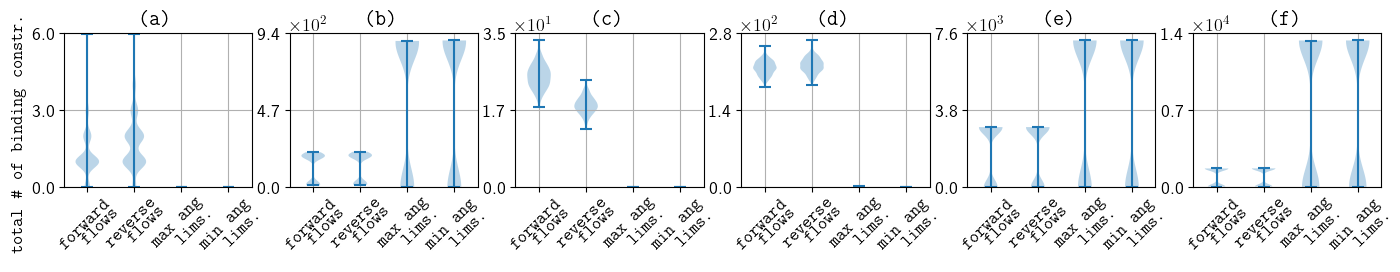

In [67]:
import os, pickle
import numpy as np
import torch.nn.functional as F
from oct2py import Oct2Py
import cyipopt
import warnings
from tqdm import trange
from pypower.ext2int import ext2int
from pypower.api import loadcase
from problemDefJITM2 import opfSocp
from problemDefJITR2 import opfSocpR
from utils import make_data_parallel
from tqdm import tqdm, trange
from itertools import zip_longest
import gc
from time import time
from ConvexModel import ConvexNet
from ClassifierModel import ClassifierNet
from RidgeModel import RidgeNet
import xgboost as xgb
from matplotlib.ticker import ScalarFormatter

from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import RidgeClassifier

octave = Oct2Py()
dir_name = 'data/'
MAX_BUS = 10000
NUM_SOLVES = 30
VIOL_THRES = 1e-5

if __name__ == "__main__":
    
    # get all cases in current directory
    current_directory = os.getcwd()+'/'
    # current_directory = '/home/sbose/pglib-opf/' # for running on BEBOP
    all_files_and_directories = os.listdir(current_directory)
    # three specific cases
    case_files = [current_directory+i for i in ['pglib_opf_case118_ieee.m','pglib_opf_case793_goc.m','pglib_opf_case1354_pegase.m','pglib_opf_case2312_goc.m','pglib_opf_case4601_goc.m','pglib_opf_case10000_goc.m']]
    # case_files = [current_directory+i for i in ['pglib_opf_case2312_goc.m','pglib_opf_case10000_goc.m']]
    # case_files = [current_directory+i for i in ['pglib_opf_case2312_goc.m',"pglib_opf_case4601_goc.m"]]

    cases, casenames = [], []
    cases_full, casenames_full = [], []
    
    for cf in case_files:
        octave.source(current_directory+os.path.basename(cf))
        cname = os.path.basename(cf).split('.')[0]
        num_buses = None
        # determine number of buses in the case from its name
        for ci in cname.split('_'):
            if 'case' in ci:
                num_buses = int(''.join([chr for chr in ci.replace('case','',1) if chr.isdigit()]))
        # fitler out cases with more buses than MAX_BUS
        if num_buses <= MAX_BUS:
            # convert to internal indexing
            case_correct_idx = ext2int(loadcase(octave.feval(cname)))
            # append
            cases.append(case_correct_idx)
            casenames.append(cname)
            
    perc = lambda a,b: (a/b)*100
    plt.rcParams['text.usetex'] = True
    plt.rc('text.latex', preamble=r'\renewcommand{\baselinestretch}{0.55}')
    fig,axs = plt.subplots(1,6,sharex=True,figsize=(17,2))
    plt.rcParams.update({'font.size': 13})
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    ttls = ['(a)','(b)','(c)','(d)','(e)','(f)']
    pd_all, qd_all = [], []
            
    for caseidx,(cn,this_case) in enumerate(zip(casenames,cases)):
        
        print(f"-----\nPlotting case {cn}\n-----\n\n")
        
        # modify the input
        optObj = opfSocp(this_case,cn) # generate object
        pd_this, qd_this = optObj._bus_pd, optObj._bus_qd
        pd_all.append(pd_this)
        qd_all.append(qd_this)
        
        # output  data for different methods
        # inp_data = np.load(os.getcwd()+f'/saved/{cn}_test_inp.npz')['data'] # input data
        gt_data = np.load(os.getcwd()+f'/saved/{cn}_test_gt.npz')['data'] # ground truth
        convex_data = np.load(os.getcwd()+f'/saved/{cn}_out_convex.npz')['data'] # convex data
        classifier_data = np.load(os.getcwd()+f'/saved/{cn}_out_classifier.npz')['data'] # classifier data
        ridge_data = np.load(os.getcwd()+f'/saved/{cn}_out_ridge.npz')['data'] # ridge data
        if cn not in 'pglib_opf_case10000_goc.m':
            xgboost_data = np.load(os.getcwd()+f'/saved/{cn}_out_xgboost.npz')['data'] # xgboost data
        else:
            xgboost_data = np.ones_like(ridge_data)
        
        # define indices
        counter = 0
        idx_flow_f = np.arange(counter,counter+optObj.n_branch).astype(int)
        counter += optObj.n_branch
        idx_flow_t = np.arange(counter,counter+optObj.n_branch).astype(int)
        counter += optObj.n_branch
        idx_ang_min = np.arange(counter,counter+optObj.n_branch).astype(int)
        counter += optObj.n_branch
        idx_ang_max = np.arange(counter,counter+optObj.n_branch).astype(int)
        counter += optObj.n_branch
        
        # calculate gt data
        counter = 0
        counter2 = int(1e+7)
        # gt = gt_data[:,counter:counter2]
        # cnv = convex_data[:,counter:counter2]
        # cla = classifier_data[:,counter:counter2]
        # rdg = ridge_data[:,counter:counter2]
        # xgb = xgboost_data[:,counter:counter2]
        gt = gt_data
        flow_f = gt_data[:,idx_flow_f].sum(axis=1)
        flow_t = gt_data[:,idx_flow_t].sum(axis=1)
        ang_min = gt_data[:,idx_ang_min].sum(axis=1)
        ang_max = gt_data[:,idx_ang_max].sum(axis=1)
        
        # rowidx = caseidx // 3
        # colidx = caseidx % 3
        colidx = caseidx
        
        class ScalarFormatterForceFormat(ScalarFormatter):
            def _set_format(self):  # Override function that finds format to use.
                self.format = "%1.1f"  # Give format here
        
        axs[colidx].violinplot([flow_f,flow_t,ang_min,ang_max])
        axs[colidx].yaxis.set_major_formatter(ScalarFormatterForceFormat(useMathText=True))
        axs[colidx].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        axs[colidx].set_xticks([1,2,3,4])
        axs[colidx].set_xticklabels([r"\begin{flushright}\texttt{forward\\flows}\end{flushright}",r"\begin{flushright}\texttt{reverse\\flows}\end{flushright}",r"\begin{flushright}\texttt{max ang\\lims.}\end{flushright}",r"\begin{flushright}\texttt{min ang\\lims.}\end{flushright}"], rotation=45)
        axs[colidx].set_xlim([0.5,4.5])
        axs[colidx].set_ylim(bottom=0)
        if caseidx == 0:
            axs[colidx].set_ylim([0,6.04])
        b,t = axs[colidx].get_ylim()
        axs[colidx].set_yticks([b, 0.5*(b+t), t])
        axs[colidx].grid(True)
        axs[colidx].set_title(r"\texttt{%s}"%(ttls[caseidx]))
        if caseidx == 0:
            label = axs[colidx].set_ylabel(r"\texttt{total \# of binding constr.}")
            label.set_position((label.get_position()[0], 0.35))
    plt.savefig('vioplot.pdf',format='pdf',bbox_inches='tight')
    plt.show()

-----
Plotting case pglib_opf_case118_ieee
-----


-----
Plotting case pglib_opf_case793_goc
-----


-----
Plotting case pglib_opf_case1354_pegase
-----


-----
Plotting case pglib_opf_case2312_goc
-----


-----
Plotting case pglib_opf_case4601_goc
-----


-----
Plotting case pglib_opf_case10000_goc
-----




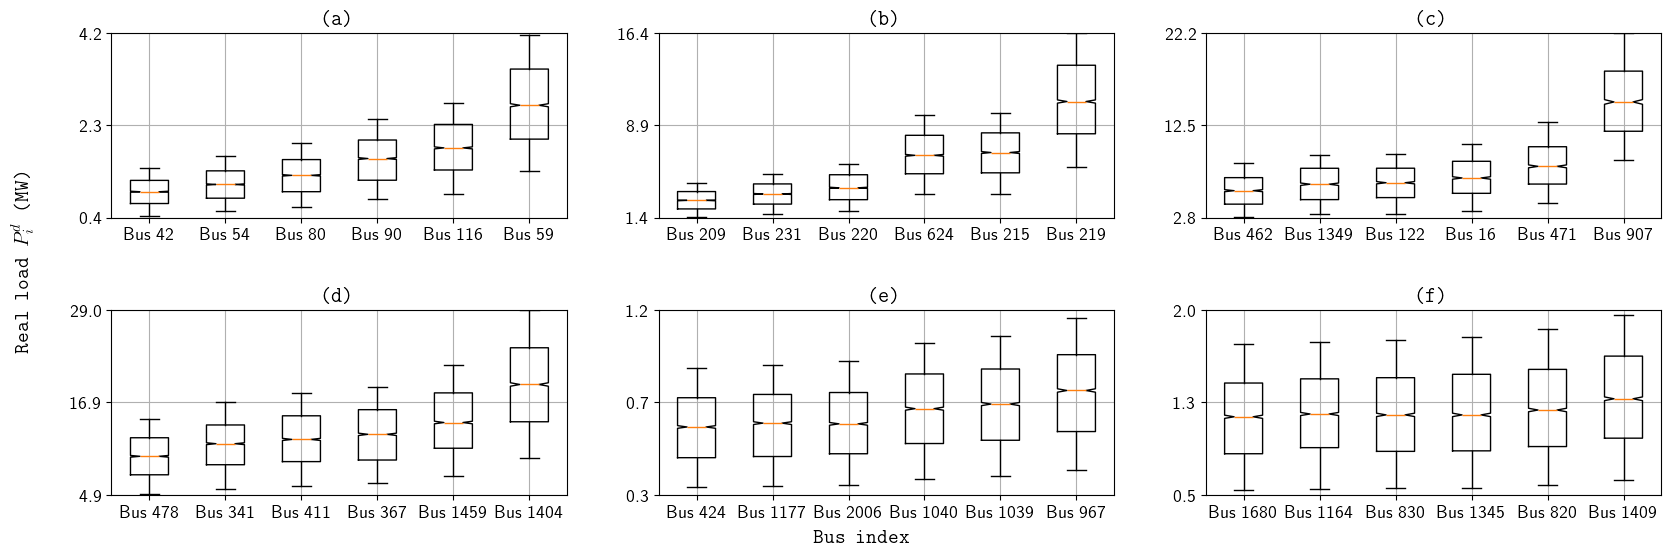

In [105]:
import os, pickle
import numpy as np
import torch.nn.functional as F
from oct2py import Oct2Py
import cyipopt
import warnings
from tqdm import trange
from pypower.ext2int import ext2int
from pypower.api import loadcase
from problemDefJITM2 import opfSocp
from problemDefJITR2 import opfSocpR
from utils import make_data_parallel
from tqdm import tqdm, trange
from itertools import zip_longest
import gc
from time import time
from ConvexModel import ConvexNet
from ClassifierModel import ClassifierNet
from RidgeModel import RidgeNet
import xgboost as xgb
from matplotlib.ticker import ScalarFormatter

from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import RidgeClassifier

octave = Oct2Py()
dir_name = 'data/'
MAX_BUS = 10000
NUM_SOLVES = 30
VIOL_THRES = 1e-5
MAX_LINES_PLOT = 200
TOP_K = 5

if __name__ == "__main__":
    
    # get all cases in current directory
    current_directory = os.getcwd()+'/'
    # current_directory = '/home/sbose/pglib-opf/' # for running on BEBOP
    all_files_and_directories = os.listdir(current_directory)
    # three specific cases
    case_files = [current_directory+i for i in ['pglib_opf_case118_ieee.m','pglib_opf_case793_goc.m','pglib_opf_case1354_pegase.m','pglib_opf_case2312_goc.m','pglib_opf_case4601_goc.m','pglib_opf_case10000_goc.m']]
    # case_files = [current_directory+i for i in ['pglib_opf_case2312_goc.m','pglib_opf_case10000_goc.m']]
    # case_files = [current_directory+i for i in ['pglib_opf_case2312_goc.m',"pglib_opf_case4601_goc.m"]]

    cases, casenames = [], []
    cases_full, casenames_full = [], []
    c_num_buses = []
    
    for cf in case_files:
        cname = os.path.basename(cf).split('.')[0]
        num_buses = None
        # determine number of buses in the case from its name
        for ci in cname.split('_'):
            if 'case' in ci:
                num_buses = int(''.join([chr for chr in ci.replace('case','',1) if chr.isdigit()]))
        # fitler out cases with more buses than MAX_BUS
        if num_buses <= MAX_BUS:
            # append
            cases.append(None)
            casenames.append(cname)
            c_num_buses.append(num_buses)
            
    perc = lambda a,b: (a/b)*100
    plt.rcParams['text.usetex'] = True
    plt.rc('text.latex', preamble=r'\renewcommand{\baselinestretch}{0.55}')
    fig,axs = plt.subplots(2,3,figsize=(20,6))
    plt.rcParams.update({'font.size': 13})
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    ttls = ['(a)','(b)','(c)','(d)','(e)','(f)']
            
    for caseidx,(cn,this_case,n_bus) in enumerate(zip(casenames,cases,c_num_buses)):
        
        print(f"-----\nPlotting case {cn}\n-----\n\n")
        
        # modify the input
        # optObj = opfSocp(this_case,cn) # generate object
        
        # output  data for different methods
        inp_data = np.load(os.getcwd()+f'/saved/{cn}_test_inp.npz')['data'] # input data
        # gt_data = np.load(os.getcwd()+f'/saved/{cn}_test_gt.npz')['data'] # ground truth
        # convex_data = np.load(os.getcwd()+f'/saved/{cn}_out_convex.npz')['data'] # convex data
        # classifier_data = np.load(os.getcwd()+f'/saved/{cn}_out_classifier.npz')['data'] # classifier data
        # ridge_data = np.load(os.getcwd()+f'/saved/{cn}_out_ridge.npz')['data'] # ridge data
        # if cn not in 'pglib_opf_case10000_goc.m':
        #     xgboost_data = np.load(os.getcwd()+f'/saved/{cn}_out_xgboost.npz')['data'] # xgboost data
        # else:
        #     xgboost_data = np.ones_like(ridge_data)
        pd_largest_idx = np.argsort(pd_all[caseidx])[-(TOP_K+1):]
        
        # define indices
        # counter = 0
        # idx_flow_f = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        # idx_flow_t = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        # idx_ang_min = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        # idx_ang_max = np.arange(counter,counter+optObj.n_branch).astype(int)
        # counter += optObj.n_branch
        pd = inp_data[:,pd_largest_idx]
        
        
        # gt = gt_data[:,counter:counter2]
        # cnv = convex_data[:,counter:counter2]
        # cla = classifier_data[:,counter:counter2]
        # rdg = ridge_data[:,counter:counter2]
        # xgb = xgboost_data[:,counter:counter2]
        # inp = inp_data
        # flow_f = inp[:,idx_flow_f].sum(axis=1)
        # flow_t = inp[:,idx_flow_t].sum(axis=1)
        # ang_min = inp[:,idx_ang_min].sum(axis=1)
        # ang_max = inp[:,idx_ang_max].sum(axis=1)
        
        rowidx = caseidx // 3
        colidx = caseidx % 3
        
        class ScalarFormatterForceFormat(ScalarFormatter):
            def _set_format(self):  # Override function that finds format to use.
                self.format = "%1.1f"  # Give format here
        
        # x = np.arange(1,n_bus+1)
        # for pline,qline in zip(pd,qd):
        #     axs[rowidx,colidx].plot(x,pline,'r',linewidth=0.1,alpha=0.01)
        axs[rowidx,colidx].boxplot(pd,notch=True)
            # axs[rowidx,colidx].plot(pline,'b',linewidth=0.1,alpha=0.02)
        axs[rowidx,colidx].yaxis.set_major_formatter(ScalarFormatterForceFormat(useMathText=True))
        axs[rowidx,colidx].ticklabel_format(axis='y')
        axs[rowidx,colidx].set_xticks([1,2,3,4,5,6])
        axs[rowidx,colidx].set_xticklabels([r"Bus %s"%(str(pd_largest_idx[i]+1)) for i in range(pd_largest_idx.size)])
        axs[rowidx,colidx].set_xlim([0.5,pd_largest_idx.size+0.5])
        axs[rowidx,colidx].set_ylim([pd.min()-0.04,pd.max()+0.04])
    #     if caseidx == 0:
    #         axs[colidx].set_ylim([0,6.04])
        b,t = axs[rowidx,colidx].get_ylim()
        axs[rowidx,colidx].set_yticks([b, 0.5*(b+t), t])
        axs[rowidx,colidx].grid(True)
        axs[rowidx, colidx].set_title(r"\texttt{%s}"%(ttls[caseidx]))
    #     if caseidx == 0:
    #         axs[colidx].set_ylabel(r"\texttt{total \# of constraints}")
    # plt.savefig('vioplot.pdf',format='pdf',bbox_inches='tight')
    fig.subplots_adjust(hspace=0.5)
    fig.text(0.5, 0.04, r'\texttt{Bus index}', ha='center', va='center',fontsize=15)
    fig.text(0.08, 0.5, r'\texttt{Real load $P^d_i$ (MW)}', ha='center', va='center', rotation='vertical',fontsize=15)
    plt.savefig('loadsVar.pdf',format='pdf',bbox_inches='tight')
    plt.show()

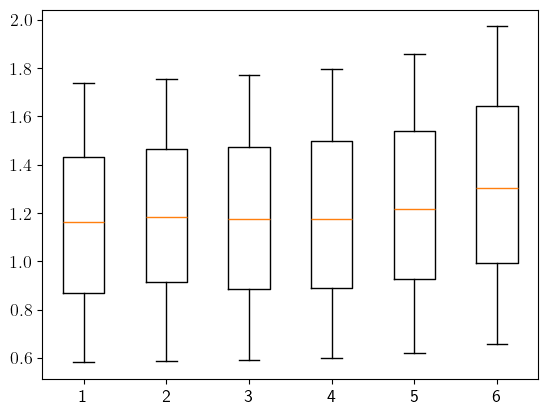

In [79]:
plt.boxplot(pd.T)
plt.show()

In [88]:
optObj.baseMVA

100.0